**Business Objective**

The goal of this project is to forecast future stock prices for companies using both statistical (ARIMA/SARIMA) and deep learning (LSTM) methods.

This helps businesses and investors to:

*   📈 Predict price trends (short-term and medium-term) for informed investment decisions.
*   🏦 Optimize portfolio management by anticipating risks and opportunities.
*   📰 Incorporate external signals (fundamentals like P/E ratio, market cap, and sentiment) to make predictions more robust.
*   ⚡ Compare classical vs deep learning approaches, identifying which model works better under different market conditions.





In [37]:
# Imports and helpers
import os, math, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)
warnings.filterwarnings("ignore")

def create_sequences(values, window):
    X, y = [], []
    for i in range(len(values) - window):
        X.append(values[i:i+window]); y.append(values[i+window])
    return np.array(X), np.array(y)

def evaluate_forecast(true, pred):
    mse = mean_squared_error(true, pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    return {'mse': mse, 'rmse': rmse, 'mae': mae}

In [38]:
## load the data
df=pd.read_csv('/content/synthetic_stock_data.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
print(df.head())

        Date      Company      Sector        Open        High        Low  \
0 2022-01-01         Uber  Technology  100.000000  101.036120  97.477809   
1 2022-01-02        Tesla  Automotive  100.071106  102.037960  97.152675   
2 2022-01-03    Panasonic     Finance   99.857828  101.517497  98.108097   
3 2022-01-04      Tencent  Automotive   98.851663  101.303783  96.998218   
4 2022-01-05  Wells Fargo  Automotive   98.391118   99.990486  96.230707   

        Close  Volume    Market_Cap   PE_Ratio  Dividend_Yield  Volatility  \
0  100.000000  171958  5.156585e+11  24.253218        0.163090    0.047484   
1  100.071106  196867  9.755658e+11  18.602848        0.288515    0.022472   
2   99.857828  181932  4.595300e+11  10.728933        2.221827    0.019991   
3   98.851663  153694  5.577481e+11  14.582696        1.377740    0.036166   
4   98.391118  169879  8.607714e+11  37.491114        3.110198    0.034770   

   Sentiment_Score    Trend  
0         0.939232  Bearish  
1         0.46

In [40]:
# Filter for one company
COMPANY = 'Moderna'
ts = df[df['Company']==COMPANY].sort_values('Date').set_index('Date')[['Close']]
print(ts.head())

                Close
Date                 
2022-01-19  99.040989
2022-03-14  94.655875
2022-03-29  94.830037
2022-05-25  98.060925
2022-05-28  99.286734


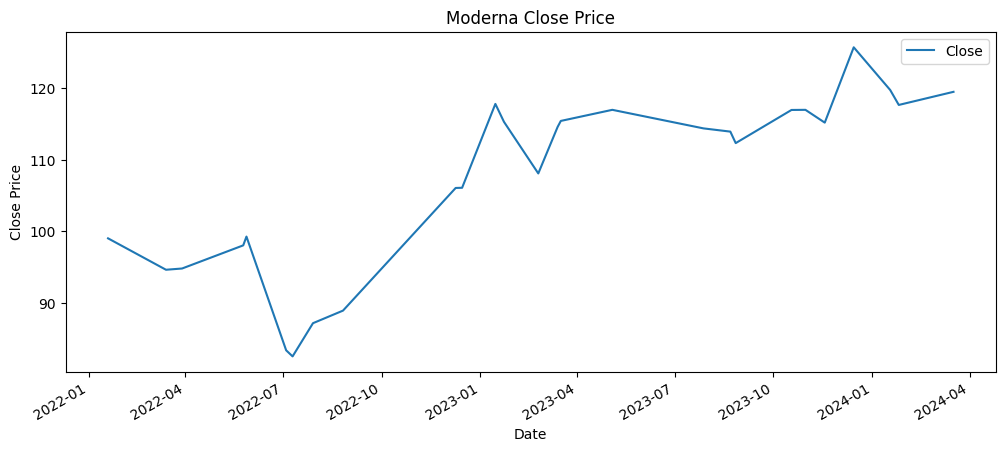

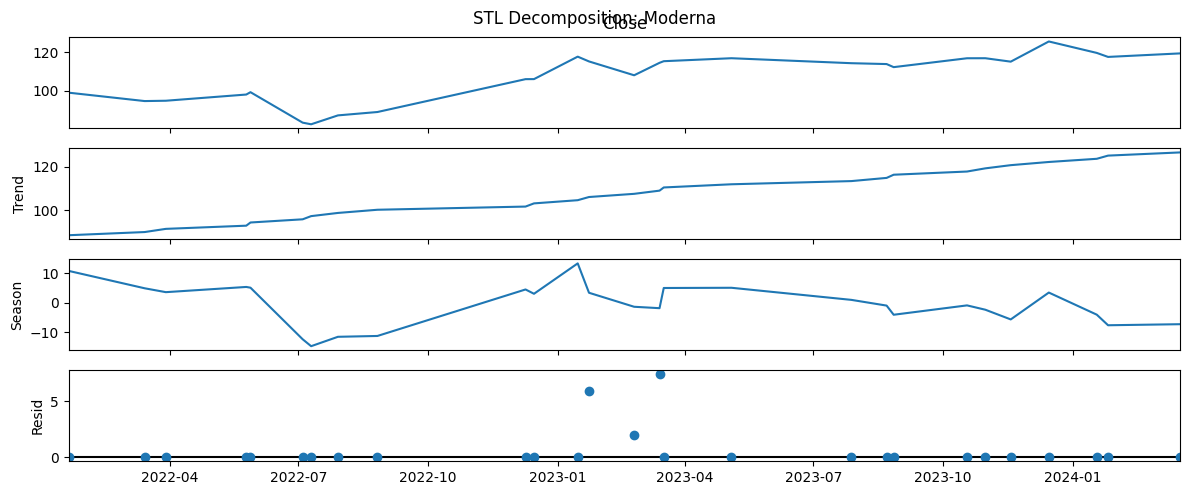

In [48]:
# Plot
ts['Close'].plot(title=f"{COMPANY} Close Price", legend=True)
plt.ylabel('Close Price')
plt.show()

# STL decomposition (trend/seasonal/resid) if long enough
try:
    from statsmodels.tsa.seasonal import STL
    if len(ts) >= 24:
        stl = STL(ts['Close'], period=12, robust=True)
        res = stl.fit()
        res.plot()
        plt.suptitle(f"STL Decomposition: {COMPANY}")
        plt.show()
    else:
        print("Series too short for seasonal decomposition (need >= 24).")
except Exception as e:
    print("STL decomposition failed:", e)


Train length: 22 Test length: 5


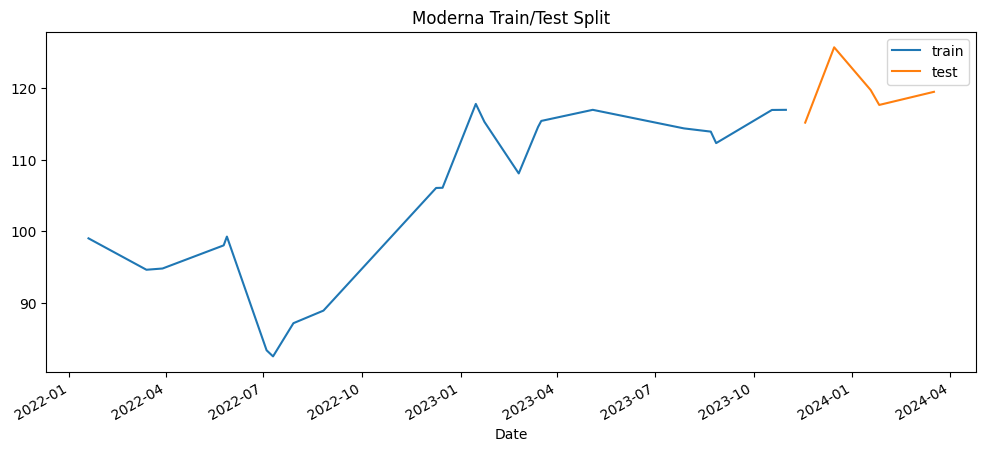

In [49]:
# We'll use the last N points for testing
TEST_SIZE = 0.2  # proportion of data as test
n_test = int(len(ts) * TEST_SIZE)
train = ts.iloc[:-n_test].copy()
test = ts.iloc[-n_test:].copy()

print("Train length:", len(train), "Test length:", len(test))
train['Close'].plot(label='train')
test['Close'].plot(label='test')
plt.legend()
plt.title(f"{COMPANY} Train/Test Split")
plt.show()


***ARIMA / SARIMA: AIC-based small grid search***

In [50]:
# quick AIC-guided grid search for p,d,q (and seasonal P,D,Q,s if seasonal)
# This is intentionally small (for speed). Increase ranges if you wish.
import warnings
warnings.filterwarnings("ignore")

p_range = range(0,3)
d_range = range(0,2)
q_range = range(0,3)

best_aic = np.inf
best_order = None
best_model = None

y_train = train['Close']

print("Searching ARIMA p,d,q grid...")

for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = ARIMA(y_train, order=(p,d,q))
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p,d,q)
                    best_model = result
            except Exception:
                continue

print("Best ARIMA order:", best_order, "AIC:", best_aic)


Searching ARIMA p,d,q grid...
Best ARIMA order: (0, 1, 0) AIC: 139.87315290774202


***Forecast with best ARIMA and evaluate***

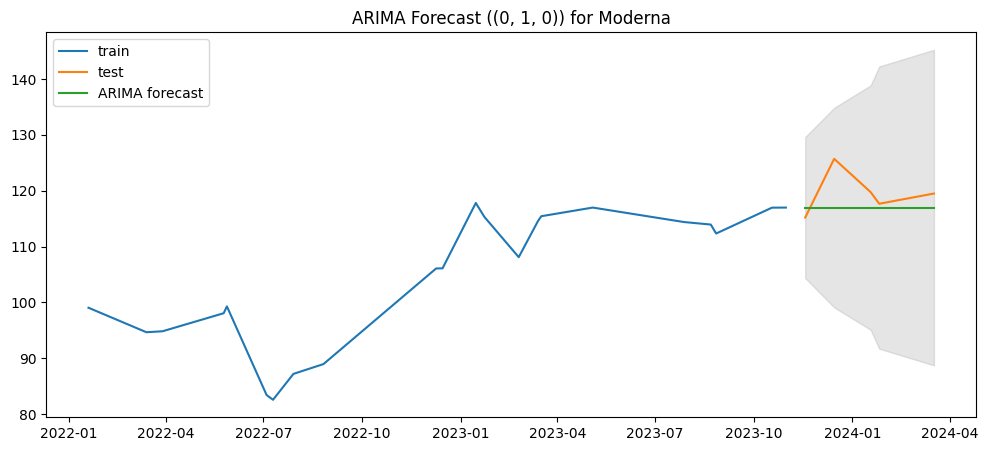

ARIMA eval: {'mse': 18.771965100743415, 'rmse': 4.3326625879178975, 'mae': 3.296503580987192}


In [51]:
# Forecast horizon
h = len(test)

# use best_model to forecast
arima_pred = best_model.get_forecast(steps=h)
arima_mean = arima_pred.predicted_mean
arima_ci = arima_pred.conf_int()

# align index
arima_mean.index = test.index
arima_ci.index = test.index

# Plot
plt.plot(train.index, train['Close'], label='train')
plt.plot(test.index, test['Close'], label='test')
plt.plot(arima_mean.index, arima_mean.values, label='ARIMA forecast')
plt.fill_between(arima_ci.index,
                 arima_ci.iloc[:,0],
                 arima_ci.iloc[:,1], color='gray', alpha=0.2)
plt.legend()
plt.title(f"ARIMA Forecast ({best_order}) for {COMPANY}")
plt.show()

# Evaluate
arima_eval = evaluate_forecast(test['Close'].values, arima_mean.values)
print("ARIMA eval:", arima_eval)


***SARIMA***

In [52]:
# If series has seasonality, try SARIMAX with seasonal period (s) e.g., 12
# Only run if you suspect seasonality (monthly data with yearly cycle)
SEASONAL = False   # set True if you want to try SARIMA
seasonal_period = 12

if SEASONAL:
    # small SARIMAX grid: (p,d,q)x(P,D,Q,s)
    P_range = range(0,2)
    D_range = range(0,2)
    Q_range = range(0,2)
    best_aic_s = np.inf
    best_order_s = None
    best_seasonal_s = None
    best_smodel = None

    for p in p_range:
        for d in d_range:
            for q in q_range:
                for P in P_range:
                    for D in D_range:
                        for Q in Q_range:
                            try:
                                smod = SARIMAX(y_train, order=(p,d,q),
                                               seasonal_order=(P,D,Q,seasonal_period),
                                               enforce_stationarity=False, enforce_invertibility=False)
                                sres = smod.fit(disp=False)
                                if sres.aic < best_aic_s:
                                    best_aic_s = sres.aic
                                    best_order_s = (p,d,q)
                                    best_seasonal_s = (P,D,Q,seasonal_period)
                                    best_smodel = sres
                            except Exception:
                                continue
    print("Best SARIMA:", best_order_s, best_seasonal_s, "AIC:", best_aic_s)

    # Forecast if found
    if best_smodel is not None:
        s_pred = best_smodel.get_forecast(steps=h)
        s_mean = s_pred.predicted_mean
        s_mean.index = test.index
        plt.plot(train.index, train['Close'], label='train')
        plt.plot(test.index, test['Close'], label='test')
        plt.plot(s_mean.index, s_mean, label='SARIMA forecast')
        plt.legend()
        plt.title(f"SARIMA Forecast for {COMPANY}")
        plt.show()
        print("SARIMA eval:", evaluate_forecast(test['Close'].values, s_mean.values))


***Prepare data for LSTM***

In [53]:
# Use MinMax scaler
scaler = MinMaxScaler(feature_range=(0,1))
close_values = ts['Close'].values.reshape(-1,1)
scaled = scaler.fit_transform(close_values)

# create train/test split indices consistent with earlier split
train_len = len(train)
scaled_train = scaled[:train_len]
scaled_test = scaled[train_len:]

# window size (lookback)
WINDOW = 20  # 20 timesteps -> predict next
X_train, y_train_seq = create_sequences(scaled_train.flatten(), WINDOW)
X_test, y_test_seq = create_sequences(np.concatenate([scaled_train.flatten()[-WINDOW:], scaled_test.flatten()]), WINDOW)

# reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


X_train shape: (2, 20, 1) X_test shape: (5, 20, 1)


In [54]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

model = Sequential([
    LSTM(64, input_shape=(WINDOW, 1), return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# training
EPOCHS = 50
BATCH = 16
history = model.fit(X_train, y_train_seq, epochs=EPOCHS, batch_size=BATCH,
                    validation_data=(X_test, y_test_seq), verbose=1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,953 (70.13 KB)

 Trainable params: 17,953 (70.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5441 - mae: 0.7376 - val_loss: 0.5568 - val_mae: 0.7418
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.4754 - mae: 0.6894 - val_loss: 0.4661 - val_mae: 0.6778
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.4255 - mae: 0.6522 - val_loss: 0.4000 - val_mae: 0.6271
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.3348 - mae: 0.5786 - val_loss: 0.3366 - val_mae: 0.5743
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.2859 - mae: 0.5345 - val_loss: 0.2742 - val_mae: 0.5171
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.3288 - mae: 0.5730 - val_loss: 0.2152 - val_mae: 0.4564
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1483 - mae: 0.3850 - val_loss: 0.1594 - val_mae: 0.3903
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1967 - mae: 0.4430 - val_loss: 0.1083 - val_mae: 0.3181
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0878 - mae: 0.2931 - 

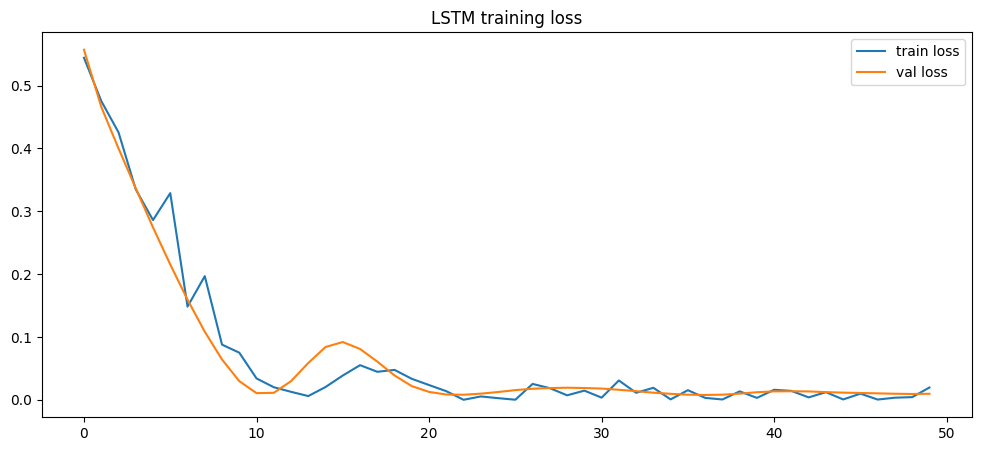

In [55]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('LSTM training loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


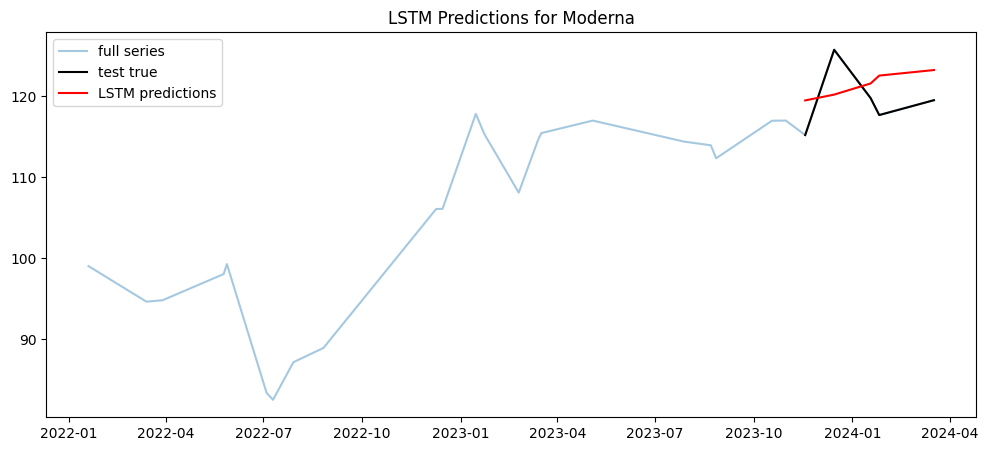

LSTM eval: {'mse': 17.912281919407356, 'rmse': 4.2322903869426725, 'mae': 4.0385196232755565}


In [56]:
# Predict on test sequences
y_pred_scaled = model.predict(X_test).flatten()

# invert scale
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

# Align predictions to proper dates: X_test starts at index train_len - WINDOW
pred_start_idx = train_len - WINDOW
pred_indices = ts.index[pred_start_idx + WINDOW: pred_start_idx + WINDOW + len(y_pred)]

# Plot
plt.plot(ts.index, ts['Close'], label='full series', alpha=0.4)
plt.plot(test.index, test['Close'], label='test true', color='black')
plt.plot(pred_indices, y_pred, label='LSTM predictions', color='red')
plt.legend()
plt.title(f"LSTM Predictions for {COMPANY}")
plt.show()

# Evaluate
lstm_eval = evaluate_forecast(y_true, y_pred)
print("LSTM eval:", lstm_eval)


***Compare ARIMA vs LSTM metrics***

In [57]:
print(f"ARIMA metrics: {arima_eval}")
print(f"LSTM metrics:  {lstm_eval}")

# Quick table
cmp = pd.DataFrame([arima_eval, lstm_eval], index=['ARIMA','LSTM'])
display(cmp)


ARIMA metrics: {'mse': 18.771965100743415, 'rmse': 4.3326625879178975, 'mae': 3.296503580987192}
LSTM metrics:  {'mse': 17.912281919407356, 'rmse': 4.2322903869426725, 'mae': 4.0385196232755565}


,mse,rmse,mae
ARIMA,18.771965,4.332663,3.296504
LSTM,17.912282,4.232290,4.038520


***Save & export models***

In [58]:
# Save LSTM model
MODEL_DIR = '/mnt/data/models'
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, f'lstm_{COMPANY}.h5'))
print("Saved LSTM model to", os.path.join(MODEL_DIR, f'lstm_{COMPANY}.h5'))

# Optionally save ARIMA results summary
with open(os.path.join(MODEL_DIR, f'arima_{COMPANY}_summary.txt'), 'w') as f:
    f.write(best_model.summary().as_text())
print("Saved ARIMA summary")


Saved LSTM model to /mnt/data/models/lstm_Moderna.h5
Saved ARIMA summary
